### This is the 3rd notebook of our Generative AI project elaborated by :
* ####  Ahmed Ben Aissa
* ####  Ismail Said
* ####  Amine Chaabini
####                                                                        
### In this notebook we used around 4000 images of landscapes found in this Kaggle dataset: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
#### 
#### We are trying to generate 64x64 images of landscapes by using a Deep Convolutional Generative Adversarial Network (DCGAN) architecture similar to the MNIST architecture with some tweaks to accomodate the difference between the 2 sets of images.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
#import all necessary libraries


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
from __future__ import print_function
import argparse
import random
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader


In [4]:
#
#
#

#### Here we will define the hyperparameters and the variables we will be using in this notebook
#### We tried different values for different variables and these are the best values we found

In [6]:
### LEARNING_RATE = 0.0005 #better results than 0.0002

BATCH_SIZE = 64

IMAGE_SIZE = 64 #because of limited time and computational resources

EPOCHS = 300 

image_channels = 3 #We will be using colored (RGB) photos

noise_channels = 256

gen_features = 64

disc_features = 64

In [7]:
#
##
###

#### Transformation of the pictures

In [8]:
#data Transformation

data_transforms = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

#### Loading the dataset

In [9]:
dataset = datasets.ImageFolder(root='/kaggle/input', transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# use GPU

device = torch.device("cuda")

In [ ]:
#
##
###
####

### Generator

In [11]:
class Generator(nn.Module):
    def __init__(self, noise_channels, image_channels, features):
        super(Generator, self).__init__()
        
        # define the model
        self.model = nn.Sequential(
            
            # Transpose block 1
            nn.ConvTranspose2d(noise_channels, features*16, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),

            # Transpose block 2
            nn.ConvTranspose2d(features*16, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.ReLU(),

            # Transpose block 3
            nn.ConvTranspose2d(features*8, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.ReLU(),

            # Transpose block 4
            nn.ConvTranspose2d(features*4, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.ReLU(),

            # Last transpose block (different)
            nn.ConvTranspose2d(features*2, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.model(x)

### Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self, image_channels, features):
        super(Discriminator, self).__init__()
        
        # define the model
        self.model = nn.Sequential(
            
            # define the first Conv block
            nn.Conv2d(image_channels, features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Conv block 2 
            nn.Conv2d(features, features*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2),
    
            # Conv block 3
            nn.Conv2d(features*2, features*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2),

            # Conv block 4
            nn.Conv2d(features*4, features*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2),

            # Conv block 5 (different)
            nn.Conv2d(features*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#
##
###

In [13]:
generator       = Generator(noise_channels, image_channels, gen_features).to(device)
discriminator   = Discriminator(image_channels, disc_features).to(device)

#### Optimizers (Adam)

In [15]:
gen_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
disc_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

#### Loss Function

In [16]:
criterion = nn.BCELoss()

In [17]:
# defining labels for fake images and real images for the discriminator

fake_label = 0
real_label = 1

In [18]:
generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (12): Sigmoid()
  )
)

In [19]:
# define a fixed noise 

fixed_noise = torch.randn(64, noise_channels, 1, 1).to(device)

### Let's Start the training

In [21]:
import torchvision.utils as vutils
step = 0

# loop over all epochs
for epoch in range(EPOCHS):
    
    # loop over all data
    for batch_idx, (data, target) in enumerate(dataloader):
        
        # set the data to cuda
        data = data.to(device)

        # get the batch size
        batch_size = data.shape[0]
        
        # Train the discriminator model on real data
        discriminator.zero_grad()
        label = (torch.ones(batch_size) * 0.9).to(device)
        output = discriminator(data).reshape(-1)
        real_disc_loss = criterion(output, label)
        d_x = output.mean().item()

        # train the disc model on fake (generated) data
        noise = torch.randn(batch_size, noise_channels, 1, 1).to(device)
        fake = generator(noise)
        label = (torch.ones(batch_size) * 0.1).to(device)
        output = discriminator(fake.detach()).reshape(-1)
        fake_disc_loss = criterion(output, label)

        # calculate the final discriminator loss
        disc_loss = real_disc_loss + fake_disc_loss

        # apply the optimizer and gradient
        disc_loss.backward()
        disc_optimizer.step()

        # train the generator model
        generator.zero_grad()
        label = torch.ones(batch_size).to(device)
        output = discriminator(fake).reshape(-1)
        gen_loss = criterion(output, label)
        # apply the optimizer and gradient
        gen_loss.backward()
        gen_optimizer.step()

        # print losses in console
        if batch_idx % 30 == 0:
            step += 1
            
            print(
                f"Epoch: {epoch} ===== Batch: {batch_idx}/{len(dataloader)} ===== Disc loss: {disc_loss:.4f} ===== Gen loss: {gen_loss:.4f}"
            )

            ### test the model
            with torch.no_grad():
                # generate fake images
                fake_images = generator(fixed_noise)

    # save generated images
    fake_images = generator(fixed_noise)
    save_path = "generated_images_epoch_{}.png".format(epoch)
    vutils.save_image(fake_images, save_path, normalize=True)
    print("Generated images saved at '{}'".format(save_path))


Epoch: 0 ===== Batch: 0/68 ===== Disc loss: 4.8144 ===== Gen loss: 10.8530
Epoch: 0 ===== Batch: 30/68 ===== Disc loss: 1.2844 ===== Gen loss: 9.0438
Epoch: 0 ===== Batch: 60/68 ===== Disc loss: 2.6339 ===== Gen loss: 7.1559
Generated images saved at 'generated_images_epoch_0.png'
Epoch: 1 ===== Batch: 0/68 ===== Disc loss: 0.7188 ===== Gen loss: 3.6323
Epoch: 1 ===== Batch: 30/68 ===== Disc loss: 0.8908 ===== Gen loss: 2.6504
Epoch: 1 ===== Batch: 60/68 ===== Disc loss: 0.9415 ===== Gen loss: 2.8792


KeyboardInterrupt: 

#### Here we can save the state_dict of the generator and discriminator for later use (more training/ deployment etc...)

In [22]:
torch.save(generator.state_dict(), 'Gh.pth')
torch.save(discriminator.state_dict(), 'D.pth')

NameError: name 'gen_model' is not defined

### Now let's visualize some of the generated images

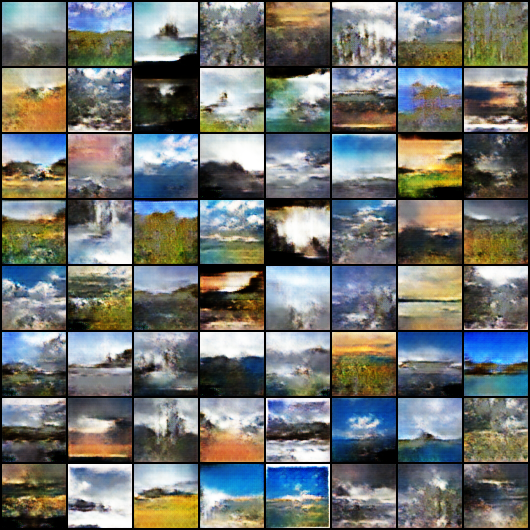

In [25]:
from IPython.display import Image

# image generated at epoch 50
Image('/kaggle/working/generated_images_epoch_50.png')

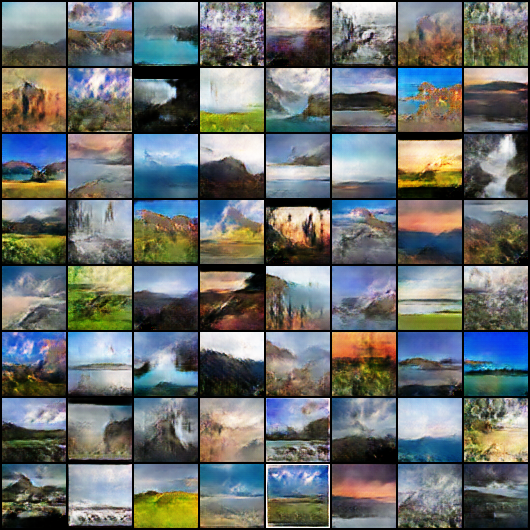

In [27]:
# image generated at epoch 100
Image('/kaggle/working/generated_images_epoch_100.png')

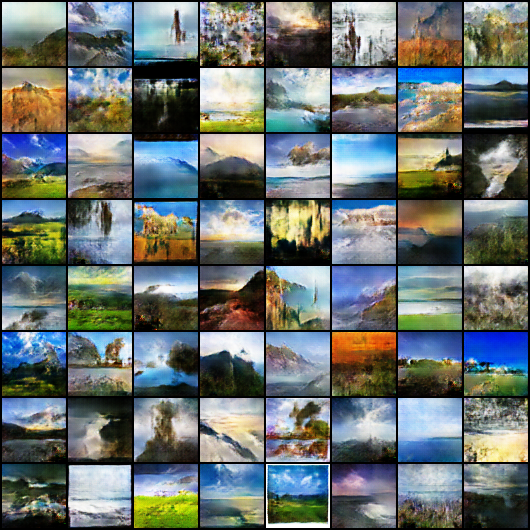

In [28]:
# image generated at epoch 200
Image('/kaggle/working/generated_images_epoch_200.png')

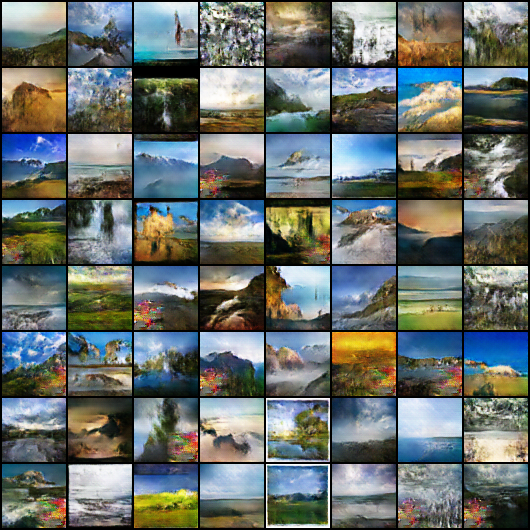

In [29]:
# image generated at epoch 299
Image('/kaggle/working/generated_images_epoch_299.png')

### Now we want to create a video of the progression of the training

In [30]:
import cv2
import os
import re


vid_fname = 'Landscapes.avi'

files = [os.path.join('/kaggle/working/', f) for f in os.listdir('/kaggle/working/') if 'generated' in f]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'
